## Overview 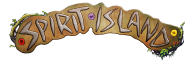

This short exercise is to gain basic competency with abstractive summarization from pre-trained NLP models using CUDA. We retrieve the transcript of a Spirit Island review video from the YouTube channel 3 Minute Board Games, which can be found here: https://www.youtube.com/watch?v=aEpGN6jswPw.

YouTubeTranscriptApi passes a list of dictionaries containing timestamps, along with the closed captions. We remove the timestamps, clean the text, and merge it all into a single string. This string is given to the following models:

* Google's Pegasus-xsum: https://huggingface.co/google/pegasus-xsum
* Facebook's BART-large-CNN: https://huggingface.co/facebook/bart-large-cnn
* Google's T5-Base: https://huggingface.co/google-t5/t5-base

Google's T5-Base is performed twice, once with a pipeline and once with a tokenizer. Summarization efficacy is not a concern in this project, so there is no fine-tuning.

In [1]:
import torch

from youtube_transcript_api import YouTubeTranscriptApi

import warnings
warnings.filterwarnings("ignore")

In [2]:
transcript = YouTubeTranscriptApi.get_transcript("aEpGN6jswPw")

In [3]:
transcript

[{'text': 'Hello and welcome to spirit island, in\nabout three minutes.',
  'start': 3.24,
  'duration': 5.439},
 {'text': "It's a game for one to four players.",
  'start': 8.679,
  'duration': 2.171},
 {'text': 'It has a solo mode.', 'start': 10.85, 'duration': 1.165},
 {'text': 'Playing time is approximately 30 minutes per player',
  'start': 12.02,
  'duration': 3.16},
 {'text': 'This is a complex game', 'start': 15.4, 'duration': 2.66},
 {'text': "Imagine if you would that you're a",
  'start': 18.58,
  'duration': 1.58},
 {'text': 'peaceful water spirit in a remote\nPacific paradise. Your days are spent',
  'start': 20.17,
  'duration': 3.54},
 {'text': 'talking to fish, making it rain, and being\nprayed to by the locals.  Then one fateful',
  'start': 23.71,
  'duration': 4.62},
 {'text': 'day. European colonists turn up and start\nclear cutting forests, damming the rivers',
  'start': 28.33,
  'duration': 4.32},
 {'text': 'and polluting your waterways. How would\nyou respond? W

In [4]:
textList=[]
for line_dict in transcript:
    textList.append(line_dict.get('text'))

In [5]:
dialogue_only=[]

for text in textList:
    if '(' in text and ')' in text:
        continue
    else:
        text = text.replace('\xa0', ' ').replace('\n', ' ').replace("\'", "").replace('  ', ' ')
        dialogue_only.append(text)

In [6]:
dialogue_only = [dialogue + ' ' if dialogue[-1] != ' ' else dialogue for dialogue in dialogue_only]

In [7]:
joined_dialogue = ''.join(dialogue_only)
joined_dialogue = joined_dialogue.replace('  ', ' ')

In [8]:
print(joined_dialogue)

Hello and welcome to spirit island, in about three minutes. Its a game for one to four players. It has a solo mode. Playing time is approximately 30 minutes per player This is a complex game Imagine if you would that youre a peaceful water spirit in a remote Pacific paradise. Your days are spent talking to fish, making it rain, and being prayed to by the locals. Then one fateful day. European colonists turn up and start clear cutting forests, damming the rivers and polluting your waterways. How would you respond? With flash floods and mass drownings of course. That is spirit island. Cooperative: each player controls their own spirit and plays together against the invaders. area control: each Spirit has tokens that represent their influence on the board and where they can use their powers. card management: each player has a set of cards that represent the powers they can use. Powers are discarded once used winning the game initially the only way to win is to remove all invaders from the

### CUDA

Below is the CUDA implementation. To assess whether CUDA is actually being used, we view the performance tab of the task manager. Below is a screenshot immediately after using Run All on this notebook.

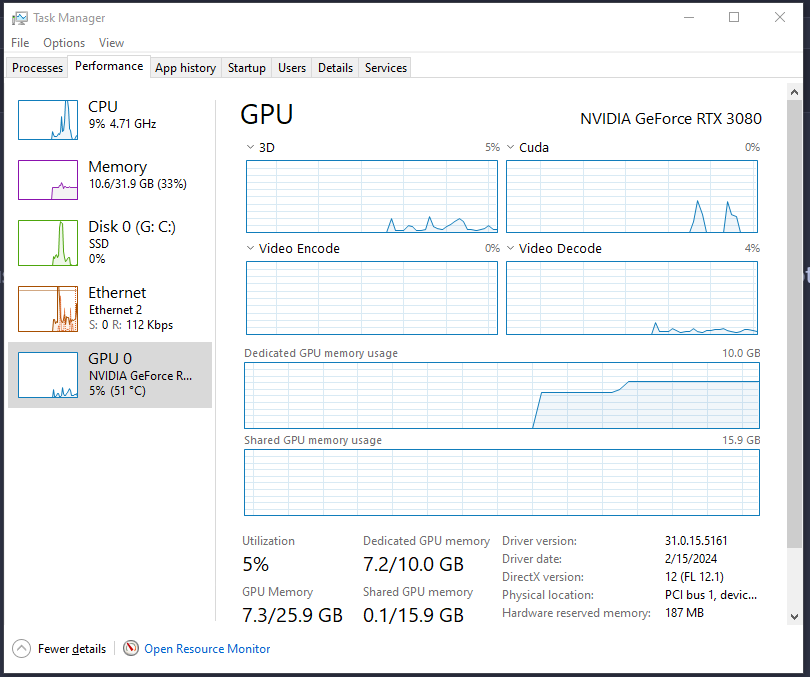

In [9]:
torch.cuda.is_available()

True

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Pegasus-xsum

In [11]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

In [12]:
pegasus_xsum_model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum").to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
pegasus_tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")

In [14]:
pegasus_tokens = pegasus_tokenizer(joined_dialogue, truncation = True, padding = True, return_tensors="pt").to(device)

In [15]:
pegasus_gen = pegasus_xsum_model.generate(**pegasus_tokens)

In [16]:
pegasus_summary = pegasus_tokenizer.decode(pegasus_gen[0], skip_special_tokens=True)

In [17]:
print(pegasus_summary)

Spirit island is a card game where players control their own spirit and use their powers to fight off invaders.


## BART-large-cnn

In [18]:
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import pipeline

In [19]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

In [20]:
bart_summary = summarizer(joined_dialogue, max_length=130, min_length=30, do_sample=False)

In [21]:
print(bart_summary[0].get('summary_text'))

Each player controls their own spirit and plays together against the invaders. Fear is the key to victory, you must make the invaders fear you when you destroy a town or city you create fear.


## T5-base via tokenizer

In [22]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [23]:
t5_tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-base").to(device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [24]:
t5_tokens = t5_tokenizer.encode('summarize'+joined_dialogue, return_tensors="pt", max_length=512, truncation=True).to(device)

In [25]:
summary_ids = t5_model.generate(t5_tokens, max_length=50)

In [26]:
print(t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True))

spirit island is a complex game for one to four players. each player controls their own spirit and plays together against the invaders.


## T5-base via pipeline

In [27]:
t5pipeline = pipeline("summarization", model="google-t5/t5-base",device=device)

In [28]:
print(t5pipeline(joined_dialogue, min_length=25, max_length=50)[0].get('summary_text'))

spirit island is a game for one to four players and has a solo mode . each player controls their own spirit and plays together against the invaders . the game is not casual gamer friendly .
